# MNIST Database:

In [1]:
import sys
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Warning: since Scikit-Learn 0.24, fetch_openml() returns a Pandas DataFrame by default. To avoid this and keep the same code as in the book, we use as_frame=False.



In [2]:
from sklearn.datasets import fetch_openml
mnist=fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]
print(X.shape,y.shape)


(70000, 784) (70000,)


Saving figure some_digit_plot


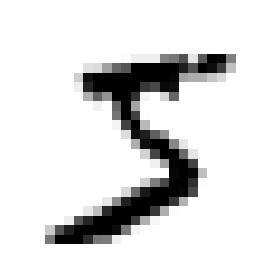

In [4]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

In [5]:
#checking it's target (or the label)
print('Label :',y[0])

Label : 5


ML algorithms mostly take numbers whereas here we've given them a string.
So we need to convert it into a number.

In [6]:
y=y.astype(np.uint8)

We always need to split the data into a training and test set.
Here, they've already done the splitting for us, but there's no harm in doing it again!

In [7]:
X_train, X_test, y_train, y_test= X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier:
we simplify our problem by trying to classify only 1 digit: 5

In [8]:
y_train_5=(y_train==5) #true for all 5, false otherwise   #created a label!
y_test_5=(y_test==5)

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf=SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [10]:
sgd_clf.predict([some_digit])

array([ True])

## Performance measures:


#### Implementing a cross-validation

In [11]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf,X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds=StratifiedKFold(n_splits=3,shuffle=True ,random_state=42)

for train_index, test_index in skfolds.split(X_train,y_train_5):
    clone_clf=clone(sgd_clf)
    X_train_folds=X_train[train_index]
    y_train_folds=y_train[train_index]
    X_test_fold=X_train[test_index]
    y_test_fold=y_train_5[test_index]

    clone_clf.fit(X_train_folds,y_train_folds)
    y_pred=clone_clf.predict(X_test_fold)
    n_correct=sum(y_pred ==y_test_fold)
    print(n_correct/len(y_pred))

0.1005
0.10405
0.0993


We use a rather basic classifier here. We'll need to create it!

In [13]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):  #see that it inherited from BaseEstimator
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)

never_5_clf=Never5Classifier()
cross_val_score(never_5_clf,X_train,y_train_5, cv=3,scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

#### Confusion Matrix

In [14]:
from sklearn.model_selection import cross_val_predict

y_train_pred=cross_val_predict(sgd_clf,X_train, y_train_5, cv=3)



In [15]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [16]:
y_train_perfect_conditions=y_train_5  #pretending perfection
confusion_matrix(y_train_5,y_train_perfect_conditions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

#### Precision and Recall

In [17]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred), recall_score(y_train_5,y_train_pred))



0.8370879772350012 0.6511713705958311


In [18]:
#F1 score in the HM manner (without libraries)
F1_score_self=(2/( (1/precision_score(y_train_5,y_train_pred)) + (1/recall_score(y_train_5, y_train_pred))))

#with sklearn
from sklearn.metrics import f1_score
f1_score(y_train_5,y_train_pred)

print(F1_score_self,f1_score(y_train_5,y_train_pred))

#see that they print the same values!


0.7325171197343847 0.7325171197343846


#### Precision-recall tradeoffs:

In [19]:
y_scores=sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

This method allows us to predict in a different manner:

In [20]:
threshold1=0
y_some_digit_pred=(y_scores> threshold1)
y_some_digit_pred

array([ True])

Now changing the threshold to a greater value:

In [21]:
threshold2=8000
y_some_digit_pred2=(y_scores > threshold2)
y_some_digit_pred2

array([False])

Now developing a method to choose the perfect threshold given to us:

In [22]:
y_scores=cross_val_predict(sgd_clf, X_train,y_train_5,cv=3,method='decision_function')

In [23]:
from sklearn.metrics import precision_recall_curve
precisions, recall, thresholds= precision_recall_curve(y_train_5,y_scores)


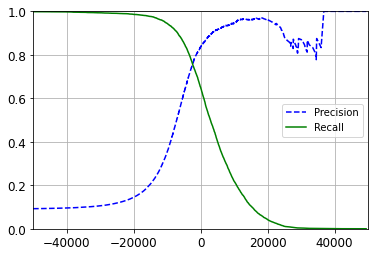

In [24]:
#using Matplotlib to plot this:

def plot_precision_recall_vs_threshold(precisions,recalls,thresholds):
    plt.plot(thresholds, precisions[:-1],'b--', label="Precision")
    plt.plot(thresholds, recall[:-1],'g-', label="Recall")
    plt.legend(loc='center right', fontsize='10')
    plt.grid(True)
    plt.axis([-50000,50000, 0,1])
plot_precision_recall_vs_threshold(precisions,recall, thresholds)
plt.show()

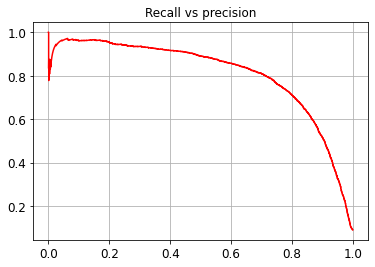

In [25]:
plt.plot(recall[:-1], precisions[:-1],'r-')
plt.title("Recall vs precision")
plt.grid(True)

In [26]:
#looking for a particular threshold value here:

threshold_90_precision=thresholds[np.argmax(precisions>=0.9)]
recall_90_precision = recall[np.argmax(precisions >= 0.90)]

y_90_pred=(y_scores>=threshold_90_precision)

y_90_pred


array([False, False, False, ...,  True, False, False])

Saving figure precision_recall_vs_threshold_plot


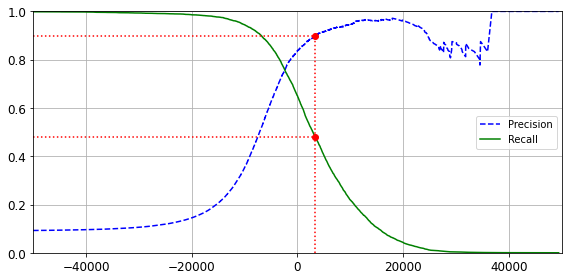

In [27]:
plt.figure(figsize=(8, 4))                                                                 
plot_precision_recall_vs_threshold(precisions, recall, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             
save_fig("precision_recall_vs_threshold_plot")                                              
plt.show()

In [28]:
print(precision_score(y_train_5, y_90_pred), recall_score(y_train_5,y_90_pred))

0.9000345901072293 0.4799852425751706


#### ROC curve:

In [29]:
from sklearn.metrics import roc_curve

fpr,tpr,thresholds_new=roc_curve(y_train_5, y_scores)

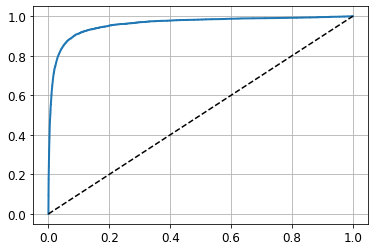

In [30]:
def plot_roc_curve(fpr, tpr, label="None"):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.grid(True)
    plt.plot([0,1],[0,1],'k--')
    

plot_roc_curve(fpr, tpr)
plt.show()
    

In [31]:
#checking it's Area under the curce score.
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5,y_scores)


0.9604938554008616

Entering a `RandomForestClassifier` in the middle.

In [32]:
from sklearn.ensemble import RandomForestClassifier

forest_clf=RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")


In [33]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

roc_curve(y_train_5, y_scores_forest)

(array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.83220653e-05, 5.49661958e-05, 5.49661958e-05, 5.49661958e-05,
        5.49661958e-05, 5.49661958e-05, 9.16103263e-05, 9.16103263e-05,
        1.09932392e-04, 1.09932392e-04, 1.09932392e-04, 1.09932392e-04,
        1.28254457e-04, 1.28254457e-04, 1.64898587e-04, 2.19864783e-04,
        2.19864783e-04, 2.56508914e-04, 2.56508914e-04, 2.74830979e-04,
        2.93153044e-04, 2.93153044e-04, 3.48119240e-04, 3.84763371e-04,
        4.21407501e-04, 4.39729566e-04, 4.58051632e-04, 5.13017827e-04,
        5.49661958e-04, 6.22950219e-04, 6.96238480e-04, 6.96238480e-04,
        7.51204676e-04, 8.24492937e-04, 8.97781198e-04, 1.08100185e-03,
        1.13596805e-03, 1.28254457e-03, 1.42912109e-03, 1.520731

Saving figure roc_curve_comparison_plot


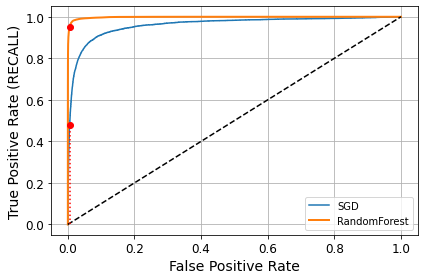

In [34]:
plt.plot(fpr,tpr, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, label="RandomForest")
plt.legend(loc="lower right")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (RECALL)")

fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]          
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]


plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # draws a red dashed line
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # makes the dashed red line
plt.plot([fpr_90], [recall_90_precision], "ro")               # places that red dot
plt.plot([fpr_90], [recall_for_forest], "ro")
save_fig("roc_curve_comparison_plot")                                    # saves the figure
plt.show()




## MULTIPLE CLASSIFICATION:

First we'll be using a SVM because it's binary, and we need to demonstrate the OvR and OvO:


In [35]:
from sklearn.svm import SVC
svm_clf=SVC()
svm_clf.fit(X_train, y_train)  #note that here we gave y_train and not y_train_5, because we need to shows OvR.
svm_clf.predict([some_digit])

array([5], dtype=uint8)

this is a parallel of the y_scores we trained earlier for y_train_5. It gives us 10 scores because it has 10 instances, so 1 per instance (OvR).

In [37]:
some_digit_scores= svm_clf.decision_function([some_digit]) 
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

`argmax()` gives us the first index of the maximum value. 

In [38]:
np.argmax([some_digit_scores])


5

Any classifier stores the list of targets in it's `classes_` attribute, ordered by value!

In [39]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

Now we train a OvO and a OvR. Scikitlearn is capable of doing that much!
Note that the following lines of code takes 30< mins to run, so I am not running!! 

In [ ]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf=OneVsRestClassifier(SVC())
ovr_clf.fit(X_train,y_train)
ovr_clf.predict([some_digit])


In [ ]:
len(ovr_clf.estimators_)

training a SGD classifier, which is already modelled to take more than 1 classes. 

In [42]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [43]:
sgd_clf.decision_function([some_digit])


array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

Following lines of codes is evaluating the models usin the `cross_val_score`.
*these will take more than 30-40mins to run, hence not running*

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")


Here we are scaling the inputs to increase accuracy

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

## Error Analysis

In [44]:
y_train_pred=cross_val_predict(sgd_clf, X_train, y_train, cv=3)
conf_mat=confusion_matrix(y_train, y_train_pred)
conf_mat

array([[5635,    0,   61,   10,   16,   50,   46,    7,   66,   32],
       [   3, 6393,   95,   21,   16,   47,   15,   27,  109,   16],
       [  72,   56, 5174,   89,   69,   39,  163,   66,  212,   18],
       [  58,   32,  217, 4941,   23,  441,   32,   56,  216,  115],
       [  11,   26,   46,    6, 5298,   26,   73,   32,   87,  237],
       [  68,   23,   58,  150,   83, 4606,  174,   26,  152,   81],
       [  40,   13,   56,    6,   22,  113, 5625,    5,   36,    2],
       [  23,   24,  103,   36,  124,   40,   10, 5228,   75,  602],
       [  40,  101,  158,  122,   49,  457,   77,   35, 4666,  146],
       [  33,   18,   66,   83,  515,  127,    4,  485,  166, 4452]],
      dtype=int64)

Visualizing it:

<Figure size 576x576 with 0 Axes>

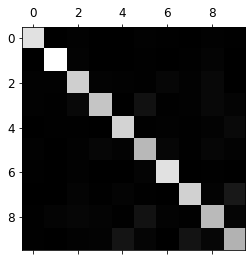

Saving figure Confusion_matrix for y_train vs y_train_pred in SGD class


<Figure size 432x288 with 0 Axes>

In [49]:
plt.figure(figsize=(8, 8))                                                                 
plt.matshow(conf_mat, cmap=plt.cm.gray)
plt.show()
save_fig("Confusion_matrix for y_train vs y_train_pred in SGD class")

Now focusing on the errors:

we divide each value n the matrix by the number of images in the corresponding class. 

Wherein ROWS REPRESENT CLASS (ACTUAL), and COLUMNS ARE THE PREDICTIONS.

In [52]:
row_sums=conf_mat.sum(axis=1, keepdims=True)  #summing up the row
norm_conf_mx=conf_mat/row_sums

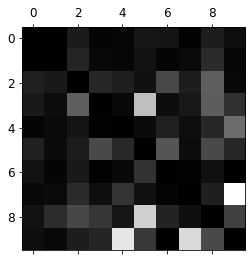

In [54]:
np.fill_diagonal(norm_conf_mx, 0) #making the diagonals=0 because we only need the errors
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Now we define a plot_digits() function and a plot_digit() function to plot a digit/digits

In [58]:
def plot_digit(data):
    image=data.reshape(28,28)   #to fit into a grid with 28x28 pixels.
    plt.imshow(image, cmap=mpl.cm.binary, interpolation="nearest")
    plt.axis("off")

In [70]:

def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Saving figure more_digits_plot


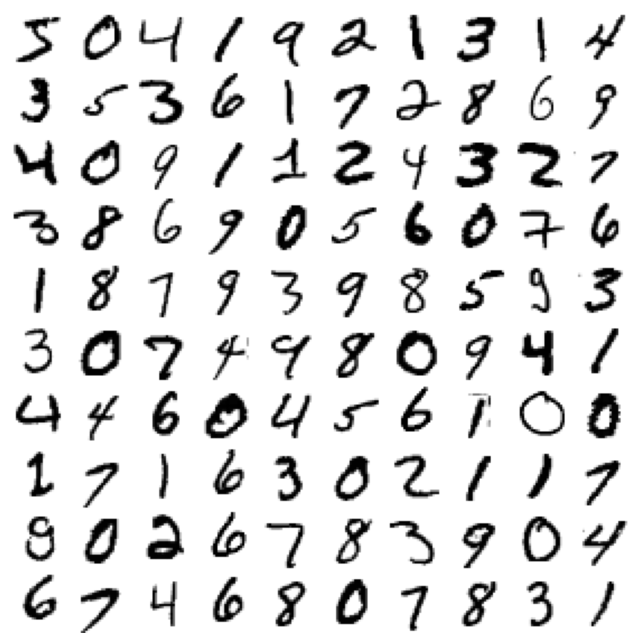

In [71]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

Saving figure error_analysis_digits_plot


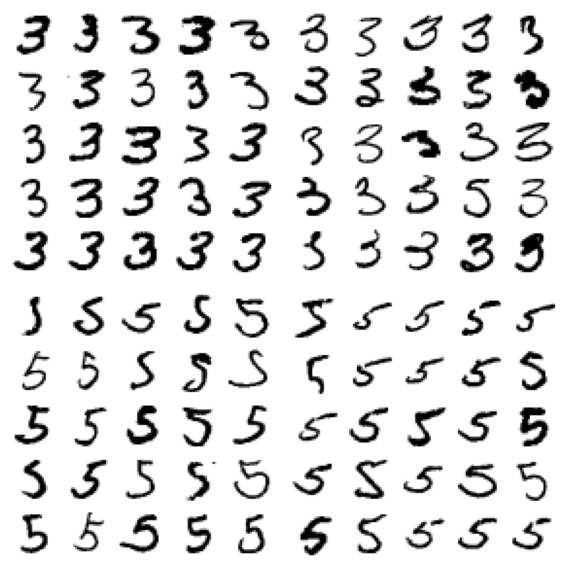

In [72]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()

## Multilabel Classification:

Here, we're training a KNN classifier to give us multiple outputs for every instance.

In [76]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf=KNeighborsClassifier()

y_train_large=(y_train>=7)     #basically label, y is large if y is greater than 7
y_train_odd=(y_train%2==1)
y_multilabel=np.c_[y_train_large, y_train_odd]   #converts 1D array into 2D ones!

knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [77]:
knn_clf.predict([some_digit])

array([[False,  True]])

Evaluating it:

In [78]:
y_train_knn_pred=cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.976410265560605

## Multi-output Classification:

In [79]:
noise=np.random.randint(0,100,(len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

Saving figure noisy_digit_example_plot


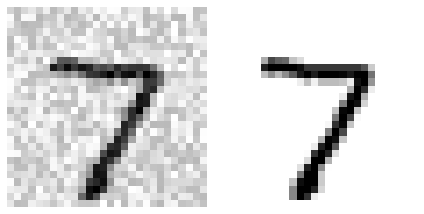

In [80]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")
plt.show()

Saving figure clean_digit-example_plot


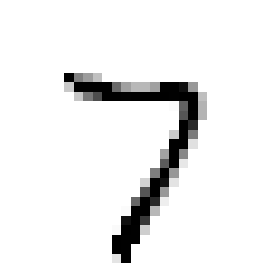

In [81]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit=knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
save_fig("clean_digit-example_plot")